The purpose of this notebook is to generate shape statistics for all objects present in the experiment, and compute an object-level shape similarity matrix. Key reference for shape statistic: 

Osada, R., Funkhouser, T., Chazelle, B., & Dobkin, D. (2002). Shape distributions. ACM Transactions on Graphics (TOG), 21(4), 807-832.
* http://graphics.stanford.edu/courses/cs468-08-fall/pdf/osada.pdf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import scipy.interpolate
from matplotlib import animation, rc
from IPython.display import HTML
import imageio
from scipy.io import loadmat
# import quaternion as qt
import plotly.graph_objects as go
import trimesh
import pyglet
import itertools
from time import perf_counter 
import pickle
import random
from scipy.stats import spearmanr
from scipy.stats import pearsonr

import visual_search_load
import visual_search_preproc
import visual_search_objects

## 1. Compute raw shape representation (can skip to 2 below)

In [19]:
direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/'
equirect_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/VisualSearchSpheres/'
## Here, we want local scale for D2 computation, and the original unscaled mesh for visualization.
# svert_direc = '/Users/angelaradulescu/Dropbox (Facebook)/VisualSearch/VisualSearchData/Expt2/Meshes/Vertices/'
vert_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/Objects/Vertices_LocalScale/'

triangles_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/Objects/Triangles/'

# Load first participant's data. 
data_direc, participant_list = visual_search_load.get_direc_participants('Expt2', direc)
participant_id = participant_list[0]
data = visual_search_load.load_processed_data_from_pickle(data_direc, participant_id.split(), ['Behavior','Eye'])

# Get all scenes. 
all_scenes = [x[1] for x in data[0]["Behavior"]["TrialOrder"]]
all_scenes.sort()

## Get all objects.
all_objects = [visual_search_load.get_all_objects(data_direc, x) for x in all_scenes]
unique_objects = np.unique(np.array([item for sublist in all_objects for item in sublist]))
unique_objects.sort()

## Load first scene info.
scene = all_scenes[0]
print(scene)
scene_info = visual_search_load.load_scene_info(data_direc, scene)

## Sort objects alphabetically. 
sorted_info = scene_info.sort_values(by=['object'])
sorted_info = sorted_info.reset_index(drop=True)
objects_in_scene = list(sorted_info['object'])

## Recode quaternions to the Python convention. 
all_quaternions = visual_search_preproc.convert_to_quaternion(sorted_info[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values)

## Get camera locations for this trial.
camera_locations = visual_search_load.load_camera_location(data_direc)
camera_location_at_trial_start = camera_locations[scene.split(' Trial ')[0]][0]
camera_rotation_at_trial_start = camera_locations[scene.split(' Trial ')[0]][1]

/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Behavior.txt
/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Eye.txt
Bathroom Location 1 Trial 1


### Gather scene mesh information into lists. 
The loop below scales and rotates the meshes to match the true scale and rotation in the experiment. It is not necessary for computing D2, since the metric is shape invariant, but is useful for visualizing meshes in the scene context. 

In [20]:
vertices_list = []
vertices_polar_list = []
triangles_list = []

for obj_idx in np.arange(len(objects_in_scene)):

    ## Get object name.
    obj_name = objects_in_scene[obj_idx]
    
    ## Open vertices file.
    vertices_path = vert_direc + obj_name + ".txt"
    vertices_file = open(vertices_path, "r")
    
    ## Open triangles file.
    triangles_path = triangles_direc + obj_name + ".txt"
    triangles_file = open(triangles_path, "r")

    ## Parse triangles and add to list.
    lines_t = triangles_file.read().split('\n')
    triangles_file.close();
    triangles = []
    for i in lines_t:
        triangles.append(int(i))
    triangles_array = np.hstack(triangles)
    triangles_array_reshaped = np.reshape(triangles_array,(int(len(triangles_array)/3), 3))
    triangles_list.append(triangles_array)
    
    ## Transform vertices and add to list.
    # Parse text file.
    lines_v = vertices_file.read().split('\n')
    vertices_file.close();
    vertices_array = np.vstack([np.array(list(map(float, l.split()))) for l in lines_v])
    n_verts, d = np.shape(vertices_array)
    # Rotate.
    obj_quaternion = all_quaternions[obj_idx]; 
    for v in np.arange(n_verts):
        vertices_array[v,:] = qt.rotate_vectors(obj_quaternion, vertices_array[v,:])
    # Translate and scale..
    vertices_array = vertices_array*sorted_info['scale'].values[obj_idx] + sorted_info[['loc_x', 'loc_y', 'loc_z']].values[obj_idx,:]
    vertices_list.append(vertices_array)
    # Subtract camera location and convert to polar.
    camera_locations_at_trial_start = np.tile(camera_location_at_trial_start, (n_verts,1))
    camera_rotations_at_trial_start = np.tile(camera_rotation_at_trial_start, (n_verts,1))
    vertices_from_camera = visual_search_preproc.rotate_gaze(camera_rotations_at_trial_start,vertices_array-camera_locations_at_trial_start)
    vertices_from_camera_polar = visual_search_preproc.convert_to_polar(visual_search_preproc.normalize(vertices_from_camera))
    # Append to list. 
    vertices_polar_list.append(vertices_from_camera_polar)    
    
all_vertices = np.vstack(vertices_list);
all_vertices_polar = np.vstack(vertices_polar_list)
all_triangles = np.hstack(triangles_list);

NameError: name 'qt' is not defined

### Visualize.

In [3]:
## Plot all mesh vertices over equirect.
# Remember to use the unscaled mesh for correct visualization. 
# Load equirect.
im = imageio.imread(equirect_direc + scene + '.png')
fig = plt.figure()
# Plot.
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im, extent=[-np.pi, np.pi, -np.pi/2, np.pi/2], aspect='auto')
ax.set_axis_off()
ax.plot(all_vertices_polar[:,0],all_vertices_polar[:,1],'.',color='r', markersize=5);

NameError: name 'scene' is not defined

## Gather vertices and triangles.

In [4]:
vertices_list = []
triangles_list = []

for obj_name in unique_objects:
    
    ## Open vertices file.
    vertices_path = vert_direc + obj_name + ".txt"
    vertices_file = open(vertices_path, "r")
    lines_v = vertices_file.read().split('\n')
    vertices_file.close();
    vertices_array = np.vstack([np.array(list(map(float, l.split()))) for l in lines_v])
    vertices_list.append(vertices_array)
    
    ## Open triangles file.
    triangles_path = triangles_direc + obj_name + ".txt"
    triangles_file = open(triangles_path, "r")

    ## Parse triangles and add to list.
    lines_t = triangles_file.read().split('\n')
    triangles_file.close();
    triangles = []
    for i in lines_t:
        triangles.append(int(i))
    triangles_array = np.hstack(triangles)
    triangles_array_reshaped = np.reshape(triangles_array,(int(len(triangles_array)/3), 3))
    triangles_list.append(triangles_array_reshaped)

NameError: name 'unique_objects' is not defined

### Plot some example meshes.

In [5]:
# 0 = airplane, 30 = candlestick, 89 = rubber duck
# 86 = plastic box 2 
random_object = 89
print(unique_objects[random_object])
fig = visual_search_objects.plot_mesh(vertices_list[random_object], triangles_list[random_object])
fig.show()

NameError: name 'unique_objects' is not defined

### Compute D2 distribution for all objects.

In [6]:
## Compute D2 distribution for all objects.
# D2_distribution = visual_search_objects.d2(vertices_list, triangles_list, 500000)

In [7]:
## Define dictionary and pickle. 
# d2_all_objects = {"unique_objects": unique_objects, "D2": D2_distribution}
# pickle_out = open("data/d2_all_objects.pickle","wb")
# pickle.dump(d2_all_objects, pickle_out)
# pickle_out.close()

## 2. Compute similarity

In [21]:
data_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'
d2_all_objects = pickle.load(open(data_direc + "/shape/d2_all_objects.pickle", "rb"))

In [22]:
d2_all_objects['D2'][0].shape

(500000, 1)

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


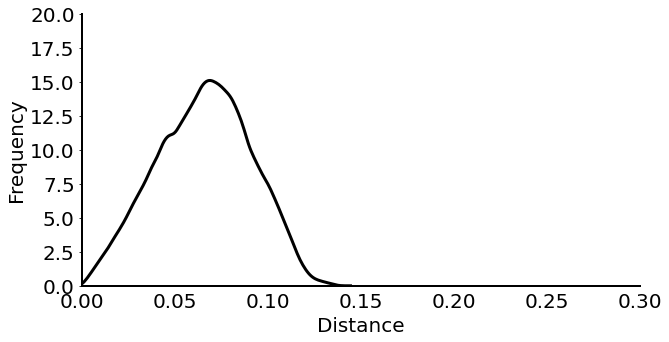

In [23]:
## Plot D2 for an object.
# 0 = airplane, 30 = candlestick, 89 = rubber duck
random_object = 89

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(d2_all_objects['D2'][random_object],hist=False,color='black',kde_kws={"lw": 3});
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim(0,0.3)
ax.set_ylim(0,20)
ax.set_xlabel('Distance', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
plt.tick_params(bottom=False)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
# ax.yaxis.set_major_locator(plt.NullLocator())
# ax.xaxis.set_major_formatter(plt.NullFormatter());
sns.despine();

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

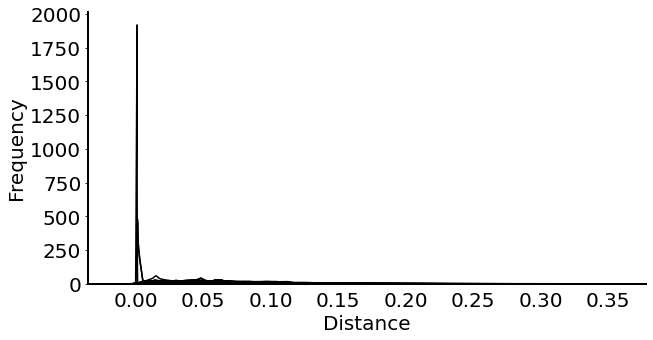

In [26]:
## Plot D2 for first N objects.
N = 106

fig, ax = plt.subplots(figsize=(10,5))
for o in np.arange(N):
    sns.distplot(d2_all_objects['D2'][o],hist=False,color='black');
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,30)
ax.set_xlabel('Distance', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
plt.tick_params(bottom=False)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
# ax.yaxis.set_major_locator(plt.NullLocator())
# ax.xaxis.set_major_formatter(plt.NullFormatter());
sns.despine();

### Pairwise similarity for all pairs of possible objects.

The loop below uses the local scale for the raw meshes, before any other transforms (eg scale and rotation) are applied. The local scale was chosen by BVO to scale the prefabs to (roughly) the same size.

In [27]:
from scipy.stats import wasserstein_distance

sim_measure = 'l2'

D2 = d2_all_objects['D2']
n_objects = len(d2_all_objects['unique_objects'])
similarity_matrix = np.zeros((n_objects, n_objects))
object_pairs = list(itertools.combinations(np.arange(n_objects), 2))

t_start = perf_counter()
for p in object_pairs:
    object_1_idx = p[0]
    object_2_idx = p[1]
    
    print("Computing distance between " + d2_all_objects['unique_objects'][object_1_idx] + " and " + d2_all_objects['unique_objects'][object_2_idx]) 
    # distance = visual_search_objects.smoothed_hist_kl_distance(D2[object_1_idx], D2[object_2_idx], nbins=100, sigma=1)
    # distance = wasserstein_distance(D2[object_1_idx].flatten(), D2[object_2_idx].flatten())
    # distance = np.linalg.norm(D2[object_1_idx].flatten()-D2[object_2_idx].flatten())
    # distance = (1-pearsonr(D2[object_1_idx].flatten(),D2[object_2_idx].flatten())[0])/2
    
    # Compute histograms.
    bins = np.arange(0, 1, 0.01)
    d2_hist_obj_1 = np.histogram(D2[object_1_idx].flatten(), bins=bins)[0]
    d2_hist_obj_2 = np.histogram(D2[object_2_idx].flatten(), bins=bins)[0]
    
    # Compute distance. 
    if (sim_measure == "l2"):
        distance = np.linalg.norm(d2_hist_obj_1-d2_hist_obj_2)
    else: 
        distance = (1-spearmanr(d2_hist_obj_1,d2_hist_obj_2)[0])/2

    ## Record. 
    similarity_matrix[object_1_idx,object_2_idx] = distance
    
    print("Distance: " + str(distance))
    assert np.isfinite(distance)
    
## Define dictionary and pickle. 
unique_objects = d2_all_objects['unique_objects']
similarity_all_objects = {"unique_objects": unique_objects, "similarity_matrix": similarity_matrix}
pickle_out = open(data_direc + "/shape/similarity_spearman.pickle","wb")
pickle.dump(similarity_all_objects, pickle_out)
pickle_out.close()
    
t_stop = perf_counter() 
print("Elapsed time for distance computation: ", t_stop-t_start)     

Computing distance between Airplane and Allergy Pills
Distance: 0.03913985692361638
Computing distance between Airplane and Apple
Distance: 0.07166692916362927
Computing distance between Airplane and Bacon
Distance: 0.012574902305204083
Computing distance between Airplane and Banana
Distance: 0.0006874919434538551
Computing distance between Airplane and Beans
Distance: 0.03917092370329067
Computing distance between Airplane and Block 1
Distance: 0.11025364565523099
Computing distance between Airplane and Block 10
Distance: 0.11025364565523099
Computing distance between Airplane and Block 2
Distance: 0.11025364565523099
Computing distance between Airplane and Block 3
Distance: 0.11025364565523099
Computing distance between Airplane and Block 4
Distance: 0.11025364565523099
Computing distance between Airplane and Block 5
Distance: 0.11025364565523099
Computing distance between Airplane and Block 6
Distance: 0.11025364565523099
Computing distance between Airplane and Block 7
Distance: 0.1

Distance: 0.025669913492542495
Computing distance between Allergy Pills and Apple
Distance: 0.03362521068676849
Computing distance between Allergy Pills and Bacon
Distance: 0.05069563139011951
Computing distance between Allergy Pills and Banana
Distance: 0.0397611925170997
Computing distance between Allergy Pills and Beans
Distance: 6.738544474393926e-05
Computing distance between Allergy Pills and Block 1
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 10
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 2
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 3
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 4
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 5
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 6
Distance: 0.0745384352568918
Computing distance between Allergy Pills and Block 7
Distance: 0.074

Distance: 0.02735323194641398
Computing distance between Allergy Pills and Vase 1
Distance: 0.0699075346775116
Computing distance between Allergy Pills and Vase 2
Distance: 0.0813871618212037
Computing distance between Allergy Pills and Vase 3
Distance: 0.017400005538286023
Computing distance between Allergy Pills and Water Bottle
Distance: 0.22485011260693571
Computing distance between Allergy Pills and Water Bottle 2
Distance: 0.015125751428231138
Computing distance between Allergy Pills and Yogurt
Distance: 0.014553097515627389
Computing distance between Apple and Bacon
Distance: 0.08113127944747717
Computing distance between Apple and Banana
Distance: 0.0715673168215743
Computing distance between Apple and Beans
Distance: 0.03432741965840064
Computing distance between Apple and Block 1
Distance: 0.043661190029580244
Computing distance between Apple and Block 10
Distance: 0.043661190029580244
Computing distance between Apple and Block 2
Distance: 0.043661190029580244
Computing dista

Distance: 0.011595336198701678
Computing distance between Bacon and Beans
Distance: 0.05112057725470581
Computing distance between Bacon and Block 1
Distance: 0.11414072187881308
Computing distance between Bacon and Block 10
Distance: 0.11414072187881308
Computing distance between Bacon and Block 2
Distance: 0.11414072187881308
Computing distance between Bacon and Block 3
Distance: 0.11414072187881308
Computing distance between Bacon and Block 4
Distance: 0.11414072187881308
Computing distance between Bacon and Block 5
Distance: 0.11414072187881308
Computing distance between Bacon and Block 6
Distance: 0.11414072187881308
Computing distance between Bacon and Block 7
Distance: 0.11414072187881308
Computing distance between Bacon and Block 8
Distance: 0.11414072187881308
Computing distance between Bacon and Block 9
Distance: 0.11414072187881308
Computing distance between Bacon and Book 1
Distance: 0.024570368966606526
Computing distance between Bacon and Book 10
Distance: 0.0245703689666

Distance: 0.105898334528918
Computing distance between Banana and Block 6
Distance: 0.105898334528918
Computing distance between Banana and Block 7
Distance: 0.105898334528918
Computing distance between Banana and Block 8
Distance: 0.105898334528918
Computing distance between Banana and Block 9
Distance: 0.105898334528918
Computing distance between Banana and Book 1
Distance: 0.012983431499510922
Computing distance between Banana and Book 10
Distance: 0.012983431499510922
Computing distance between Banana and Book 11
Distance: 0.025579395362742452
Computing distance between Banana and Book 12
Distance: 0.0005585872040561601
Computing distance between Banana and Book 2
Distance: 0.012983431499510922
Computing distance between Banana and Book 3
Distance: 0.03282396453612474
Computing distance between Banana and Book 4
Distance: 0.1091610404771925
Computing distance between Banana and Book 5
Distance: 0.0004726507111245115
Computing distance between Banana and Book 6
Distance: 0.012983431

Distance: 0.039124323533779315
Computing distance between Beans and Book 2
Distance: 0.02741693741098966
Computing distance between Beans and Book 3
Distance: 0.06942727712817176
Computing distance between Beans and Book 4
Distance: 0.14698216286297222
Computing distance between Beans and Book 5
Distance: 0.03921752387280192
Computing distance between Beans and Book 6
Distance: 0.02741693741098966
Computing distance between Beans and Book 7
Distance: 0.027719538367724506
Computing distance between Beans and Book 8
Distance: 0.027719538367724506
Computing distance between Beans and Book 9
Distance: 0.1163779118934547
Computing distance between Beans and Bread
Distance: 0.02808584478903503
Computing distance between Beans and Candle
Distance: 0.014553097515627389
Computing distance between Beans and Candlestick
Distance: 0.1564510538631923
Computing distance between Beans and Carrot
Distance: 0.13057936457159697
Computing distance between Beans and Clipboard
Distance: 0.12158182454805266

Distance: 0.20911484796622254
Computing distance between Block 1 and Carrot
Distance: 0.1837291526447687
Computing distance between Block 1 and Clipboard
Distance: 0.19226478493545274
Computing distance between Block 1 and Coconut
Distance: 0.06148721608139218
Computing distance between Block 1 and Coffee
Distance: 0.07688064040273879
Computing distance between Block 1 and Crayon 1
Distance: 0.039781006319660306
Computing distance between Block 1 and Crayon 2
Distance: 0.039781006319660306
Computing distance between Block 1 and Crayon 3
Distance: 0.039781006319660306
Computing distance between Block 1 and Crayon 4
Distance: 0.039781006319660306
Computing distance between Block 1 and Crayon 5
Distance: 0.039781006319660306
Computing distance between Block 1 and Crayon 6
Distance: 0.039781006319660306
Computing distance between Block 1 and Cup
Distance: 0.05727617161167209
Computing distance between Block 1 and Cylinder 1
Distance: 0.07971648561615796
Computing distance between Block 1 a

Distance: 0.039781006319660306
Computing distance between Block 10 and Crayon 4
Distance: 0.039781006319660306
Computing distance between Block 10 and Crayon 5
Distance: 0.039781006319660306
Computing distance between Block 10 and Crayon 6
Distance: 0.039781006319660306
Computing distance between Block 10 and Cup
Distance: 0.05727617161167209
Computing distance between Block 10 and Cylinder 1
Distance: 0.07971648561615796
Computing distance between Block 10 and Cylinder 2
Distance: 0.07971648561615796
Computing distance between Block 10 and Cylinder 3
Distance: 0.07971648561615796
Computing distance between Block 10 and Cylinder 4
Distance: 0.07971648561615796
Computing distance between Block 10 and Dodecahedron
Distance: 0.06823697635582399
Computing distance between Block 10 and Donut 1
Distance: 0.04865863018424982
Computing distance between Block 10 and Donut 2
Distance: 0.04865863018424982
Computing distance between Block 10 and Eraser
Distance: 0.05530161487467411
Computing dista

Distance: 0.04865863018424982
Computing distance between Block 2 and Donut 2
Distance: 0.04865863018424982
Computing distance between Block 2 and Eraser
Distance: 0.05530161487467411
Computing distance between Block 2 and Gold
Distance: 0.03928033745386422
Computing distance between Block 2 and Helmet
Distance: 0.05546280317973523
Computing distance between Block 2 and Juice Box
Distance: 0.09576195850496666
Computing distance between Block 2 and Key
Distance: 0.06926847367873606
Computing distance between Block 2 and Knight
Distance: 0.11243509163921434
Computing distance between Block 2 and Laptop
Distance: 0.06880003264956669
Computing distance between Block 2 and Left Shoe
Distance: 0.11985546237231415
Computing distance between Block 2 and Magazine 1
Distance: 0.08196778738594057
Computing distance between Block 2 and Magazine 2
Distance: 0.08196778738594057
Computing distance between Block 2 and Marker 1
Distance: 0.05576503125172466
Computing distance between Block 2 and Marker 

Distance: 0.08196778738594057
Computing distance between Block 3 and Marker 1
Distance: 0.05576503125172466
Computing distance between Block 3 and Marker 2
Distance: 0.05576503125172466
Computing distance between Block 3 and Marker 3
Distance: 0.05576503125172466
Computing distance between Block 3 and Marker 4
Distance: 0.02176662605357277
Computing distance between Block 3 and Milk Carton 1
Distance: 0.11732339273827064
Computing distance between Block 3 and Milk Carton 2
Distance: 0.11996096527373262
Computing distance between Block 3 and Milk Carton 3
Distance: 0.11737614418897979
Computing distance between Block 3 and Mug
Distance: 0.07457747200932258
Computing distance between Block 3 and Notebook
Distance: 0.07043957625165959
Computing distance between Block 3 and Oil Bottle 1
Distance: 0.35805193297778487
Computing distance between Block 3 and Oil Bottle 2
Distance: 0.35805193297778487
Computing distance between Block 3 and Oil Carafe 1
Distance: 0.10766205556354058
Computing di

Distance: 0.10766205556354058
Computing distance between Block 4 and Oil Carafe 2
Distance: 0.14307572855659456
Computing distance between Block 4 and Paint Can
Distance: 0.35805193297778487
Computing distance between Block 4 and Paper
Distance: 0.12403082001309124
Computing distance between Block 4 and Paper Bag
Distance: 0.08579703221398521
Computing distance between Block 4 and Paper Box
Distance: 0.07457747200932258
Computing distance between Block 4 and Pear
Distance: 0.06952221256953617
Computing distance between Block 4 and Pen
Distance: 0.04023995277997344
Computing distance between Block 4 and Pencil 1
Distance: 0.040281675185456445
Computing distance between Block 4 and Pencil 2
Distance: 0.040281675185456445
Computing distance between Block 4 and Phone
Distance: 0.09574350604495413
Computing distance between Block 4 and Picture 1
Distance: 0.14453161693552385
Computing distance between Block 4 and Picture 2
Distance: 0.12659463730453513
Computing distance between Block 4 and

Distance: 0.12659463730453513
Computing distance between Block 5 and Pills
Distance: 0.06056038332729108
Computing distance between Block 5 and Pizza Box
Distance: 0.21647596190080143
Computing distance between Block 5 and Plastic Box 1
Distance: 0.04005220195529985
Computing distance between Block 5 and Plastic Box 2
Distance: 0.04005220195529985
Computing distance between Block 5 and Raw meat
Distance: 0.12736894454020614
Computing distance between Block 5 and Right Shoe
Distance: 0.11985546237231415
Computing distance between Block 5 and Rubber Duck
Distance: 0.07305503866452207
Computing distance between Block 5 and Scissors
Distance: 0.09242206324269431
Computing distance between Block 5 and Smartphone
Distance: 0.06975643308412088
Computing distance between Block 5 and Soccer Ball
Distance: 0.059411398099416424
Computing distance between Block 5 and Soda Can
Distance: 0.021094706429191923
Computing distance between Block 5 and Takeout Box
Distance: 0.1110590478553744
Computing di

Distance: 0.0750654314147074
Computing distance between Block 6 and Teabag
Distance: 0.04011478556352438
Computing distance between Block 6 and Tomato
Distance: 0.06537588394099025
Computing distance between Block 6 and Towel
Distance: 0.2221029704693666
Computing distance between Block 6 and Train
Distance: 0.09592803064507965
Computing distance between Block 6 and Vase 1
Distance: 0.13928057607689664
Computing distance between Block 6 and Vase 2
Distance: 0.14884964951393903
Computing distance between Block 6 and Vase 3
Distance: 0.11273444261324961
Computing distance between Block 6 and Water Bottle
Distance: 0.1578509843968416
Computing distance between Block 6 and Water Bottle 2
Distance: 0.08293457692173406
Computing distance between Block 6 and Yogurt
Distance: 0.08291562026416943
Computing distance between Block 7 and Block 8
Distance: 5.551115123125783e-17
Computing distance between Block 7 and Block 9
Distance: 5.551115123125783e-17
Computing distance between Block 7 and Book

Distance: 0.08467858941767509
Computing distance between Block 8 and Book 12
Distance: 0.10762606125671154
Computing distance between Block 8 and Book 2
Distance: 0.09856673242687497
Computing distance between Block 8 and Book 3
Distance: 0.13852180572787876
Computing distance between Block 8 and Book 4
Distance: 0.2250969316308214
Computing distance between Block 8 and Book 5
Distance: 0.10672620358598572
Computing distance between Block 8 and Book 6
Distance: 0.09856673242687497
Computing distance between Block 8 and Book 7
Distance: 0.09485778796435146
Computing distance between Block 8 and Book 8
Distance: 0.09485778796435146
Computing distance between Block 8 and Book 9
Distance: 0.18663665677761687
Computing distance between Block 8 and Bread
Distance: 0.10279234576974994
Computing distance between Block 8 and Candle
Distance: 0.09216646915568316
Computing distance between Block 8 and Candlestick
Distance: 0.20911484796622254
Computing distance between Block 8 and Carrot
Distance

Distance: 0.039781006319660306
Computing distance between Block 9 and Crayon 3
Distance: 0.039781006319660306
Computing distance between Block 9 and Crayon 4
Distance: 0.039781006319660306
Computing distance between Block 9 and Crayon 5
Distance: 0.039781006319660306
Computing distance between Block 9 and Crayon 6
Distance: 0.039781006319660306
Computing distance between Block 9 and Cup
Distance: 0.05727617161167209
Computing distance between Block 9 and Cylinder 1
Distance: 0.07971648561615796
Computing distance between Block 9 and Cylinder 2
Distance: 0.07971648561615796
Computing distance between Block 9 and Cylinder 3
Distance: 0.07971648561615796
Computing distance between Block 9 and Cylinder 4
Distance: 0.07971648561615796
Computing distance between Block 9 and Dodecahedron
Distance: 0.06823697635582399
Computing distance between Block 9 and Donut 1
Distance: 0.04865863018424982
Computing distance between Block 9 and Donut 2
Distance: 0.04865863018424982
Computing distance betwe

Distance: 0.028372519379625816
Computing distance between Book 1 and Left Shoe
Distance: 0.023623412313775627
Computing distance between Book 1 and Magazine 1
Distance: 0.014087562469228487
Computing distance between Book 1 and Magazine 2
Distance: 0.014087562469228487
Computing distance between Book 1 and Marker 1
Distance: 0.045763823965861206
Computing distance between Book 1 and Marker 2
Distance: 0.045763823965861206
Computing distance between Book 1 and Marker 3
Distance: 0.045763823965861206
Computing distance between Book 1 and Marker 4
Distance: 0.08067472723174662
Computing distance between Book 1 and Milk Carton 1
Distance: 0.023924716703312754
Computing distance between Book 1 and Milk Carton 2
Distance: 0.023623412313775627
Computing distance between Book 1 and Milk Carton 3
Distance: 0.023723847110288132
Computing distance between Book 1 and Mug
Distance: 0.027735464733868342
Computing distance between Book 1 and Notebook
Distance: 0.027751391100012346
Computing distance 

Distance: 0.027401011044845713
Computing distance between Book 10 and Pear
Distance: 0.02768768563543661
Computing distance between Book 10 and Pen
Distance: 0.06329881144838401
Computing distance between Book 10 and Pencil 1
Distance: 0.06340094386433842
Computing distance between Book 10 and Pencil 2
Distance: 0.06340094386433842
Computing distance between Book 10 and Phone
Distance: 0.00012045290291495814
Computing distance between Book 10 and Picture 1
Distance: 0.05193733699587483
Computing distance between Book 10 and Picture 2
Distance: 0.03380864027528108
Computing distance between Book 10 and Pills
Distance: 0.04295248855372774
Computing distance between Book 10 and Pizza Box
Distance: 0.105910182702048
Computing distance between Book 10 and Plastic Box 1
Distance: 0.06026888310840395
Computing distance between Book 10 and Plastic Box 2
Distance: 0.06026888310840395
Computing distance between Book 10 and Raw meat
Distance: 0.03379460005844803
Computing distance between Book 10

Distance: 0.048445968678305806
Computing distance between Book 11 and Tomato
Distance: 0.031046757050709917
Computing distance between Book 11 and Towel
Distance: 0.1316321048587899
Computing distance between Book 11 and Train
Distance: 0.013453373574507654
Computing distance between Book 11 and Vase 1
Distance: 0.0570481231768491
Computing distance between Book 11 and Vase 2
Distance: 0.06787497092611405
Computing distance between Book 11 and Vase 3
Distance: 0.003702526616876034
Computing distance between Book 11 and Water Bottle
Distance: 0.22371681422897244
Computing distance between Book 11 and Water Bottle 2
Distance: 0.00022246941045622748
Computing distance between Book 11 and Yogurt
Distance: 0.00012712537740350305
Computing distance between Book 12 and Book 2
Distance: 0.012366657410829707
Computing distance between Book 12 and Book 3
Distance: 0.03183095798355823
Computing distance between Book 12 and Book 4
Distance: 0.10770298840021625
Computing distance between Book 12 an

Distance: 0.09668436995511581
Computing distance between Book 2 and Coconut
Distance: 0.04311689413338454
Computing distance between Book 2 and Coffee
Distance: 0.027496569241709345
Computing distance between Book 2 and Crayon 1
Distance: 0.06256686246737753
Computing distance between Book 2 and Crayon 2
Distance: 0.06256686246737753
Computing distance between Book 2 and Crayon 3
Distance: 0.06256686246737753
Computing distance between Book 2 and Crayon 4
Distance: 0.06256686246737753
Computing distance between Book 2 and Crayon 5
Distance: 0.06256686246737753
Computing distance between Book 2 and Crayon 6
Distance: 0.06256686246737753
Computing distance between Book 2 and Cup
Distance: 0.043051131901521766
Computing distance between Book 2 and Cylinder 1
Distance: 0.17408585726617581
Computing distance between Book 2 and Cylinder 2
Distance: 0.17408585726617581
Computing distance between Book 2 and Cylinder 3
Distance: 0.17408585726617581
Computing distance between Book 2 and Cylinder

Distance: 0.05744388725461441
Computing distance between Book 3 and Magazine 2
Distance: 0.05744388725461441
Computing distance between Book 3 and Marker 1
Distance: 0.08802850970583587
Computing distance between Book 3 and Marker 2
Distance: 0.08802850970583587
Computing distance between Book 3 and Marker 3
Distance: 0.08802850970583587
Computing distance between Book 3 and Marker 4
Distance: 0.12072209817731411
Computing distance between Book 3 and Milk Carton 1
Distance: 0.021428987509982955
Computing distance between Book 3 and Milk Carton 2
Distance: 0.020773446700588838
Computing distance between Book 3 and Milk Carton 3
Distance: 0.021088106289097963
Computing distance between Book 3 and Mug
Distance: 0.06961646949609346
Computing distance between Book 3 and Notebook
Distance: 0.0704168987449934
Computing distance between Book 3 and Oil Bottle 1
Distance: 0.41432074425351706
Computing distance between Book 3 and Oil Bottle 2
Distance: 0.41432074425351706
Computing distance betwe

Distance: 0.08556020321680052
Computing distance between Book 4 and Pills
Distance: 0.16411200553541694
Computing distance between Book 4 and Pizza Box
Distance: 0.01781939467095861
Computing distance between Book 4 and Plastic Box 1
Distance: 0.182948092049447
Computing distance between Book 4 and Plastic Box 2
Distance: 0.182948092049447
Computing distance between Book 4 and Raw meat
Distance: 0.08549382115669024
Computing distance between Book 4 and Right Shoe
Distance: 0.09609050522076767
Computing distance between Book 4 and Rubber Duck
Distance: 0.14774771044963936
Computing distance between Book 4 and Scissors
Distance: 0.12357197123484209
Computing distance between Book 4 and Smartphone
Distance: 0.1505965514688759
Computing distance between Book 4 and Soccer Ball
Distance: 0.1792594143540372
Computing distance between Book 4 and Soda Can
Distance: 0.20326364263499286
Computing distance between Book 4 and Takeout Box
Distance: 0.11743797524178928
Computing distance between Book

Distance: 0.00016562274150810907
Computing distance between Book 6 and Book 9
Distance: 0.09112584221611492
Computing distance between Book 6 and Bread
Distance: 0.0002710190315587391
Computing distance between Book 6 and Candle
Distance: 0.013685393901844478
Computing distance between Book 6 and Candlestick
Distance: 0.13117340836450386
Computing distance between Book 6 and Carrot
Distance: 0.10747171482754492
Computing distance between Book 6 and Clipboard
Distance: 0.09668436995511581
Computing distance between Book 6 and Coconut
Distance: 0.04311689413338454
Computing distance between Book 6 and Coffee
Distance: 0.027496569241709345
Computing distance between Book 6 and Crayon 1
Distance: 0.06256686246737753
Computing distance between Book 6 and Crayon 2
Distance: 0.06256686246737753
Computing distance between Book 6 and Crayon 3
Distance: 0.06256686246737753
Computing distance between Book 6 and Crayon 4
Distance: 0.06256686246737753
Computing distance between Book 6 and Crayon 5


Distance: 0.0240108036717519
Computing distance between Book 7 and Laptop
Distance: 0.027783243832300186
Computing distance between Book 7 and Left Shoe
Distance: 0.02378123842258084
Computing distance between Book 7 and Magazine 1
Distance: 0.01357711774908732
Computing distance between Book 7 and Magazine 2
Distance: 0.01357711774908732
Computing distance between Book 7 and Marker 1
Distance: 0.044062226216411926
Computing distance between Book 7 and Marker 2
Distance: 0.044062226216411926
Computing distance between Book 7 and Marker 3
Distance: 0.044062226216411926
Computing distance between Book 7 and Marker 4
Distance: 0.07741166757946621
Computing distance between Book 7 and Milk Carton 1
Distance: 0.02378123842258084
Computing distance between Book 7 and Milk Carton 2
Distance: 0.02378123842258084
Computing distance between Book 7 and Milk Carton 3
Distance: 0.02369515145414164
Computing distance between Book 7 and Mug
Distance: 0.02797436022602745
Computing distance between Boo

Distance: 0.04227020539815135
Computing distance between Book 8 and Pizza Box
Distance: 0.10717719431929329
Computing distance between Book 8 and Plastic Box 1
Distance: 0.058532632037179455
Computing distance between Book 8 and Plastic Box 2
Distance: 0.058532632037179455
Computing distance between Book 8 and Raw meat
Distance: 0.034019243527776966
Computing distance between Book 8 and Right Shoe
Distance: 0.02378123842258084
Computing distance between Book 8 and Rubber Duck
Distance: 0.027671759269292606
Computing distance between Book 8 and Scissors
Distance: 0.0008281137075404343
Computing distance between Book 8 and Smartphone
Distance: 0.027815096564588082
Computing distance between Book 8 and Soccer Ball
Distance: 0.06088167760413021
Computing distance between Book 8 and Soda Can
Distance: 0.07612059248669395
Computing distance between Book 8 and Takeout Box
Distance: 0.0019874728980968648
Computing distance between Book 8 and Tea Box
Distance: 0.027815096564588082
Computing dis

Distance: 0.06432013560792788
Computing distance between Bread and Crayon 2
Distance: 0.06432013560792788
Computing distance between Bread and Crayon 3
Distance: 0.06432013560792788
Computing distance between Bread and Crayon 4
Distance: 0.06432013560792788
Computing distance between Bread and Crayon 5
Distance: 0.06432013560792788
Computing distance between Bread and Crayon 6
Distance: 0.06432013560792788
Computing distance between Bread and Cup
Distance: 0.043864939520823654
Computing distance between Bread and Cylinder 1
Distance: 0.18498621368393658
Computing distance between Bread and Cylinder 2
Distance: 0.18498621368393658
Computing distance between Bread and Cylinder 3
Distance: 0.18498621368393658
Computing distance between Bread and Cylinder 4
Distance: 0.18498621368393658
Computing distance between Bread and Dodecahedron
Distance: 0.04417731012217185
Computing distance between Bread and Donut 1
Distance: 0.15407648758744508
Computing distance between Bread and Donut 2
Distan

Distance: 0.39800868377308907
Computing distance between Candle and Oil Bottle 2
Distance: 0.39800868377308907
Computing distance between Candle and Oil Carafe 1
Distance: 0.025700086202475825
Computing distance between Candle and Oil Carafe 2
Distance: 0.06609288336759178
Computing distance between Candle and Paint Can
Distance: 0.39800868377308907
Computing distance between Candle and Paper
Distance: 0.04660058447994814
Computing distance between Candle and Paper Bag
Distance: 0.0004290481487367881
Computing distance between Candle and Paper Box
Distance: 0.014765797540308767
Computing distance between Candle and Pear
Distance: 0.015567513017954004
Computing distance between Candle and Pen
Distance: 0.052363097600002906
Computing distance between Candle and Pencil 1
Distance: 0.05243304633074747
Computing distance between Candle and Pencil 2
Distance: 0.05243304633074747
Computing distance between Candle and Phone
Distance: 0.01405662642558353
Computing distance between Candle and Pi

Distance: 0.15673779268104254
Computing distance between Candlestick and Teabag
Distance: 0.18533614350621364
Computing distance between Candlestick and Tomato
Distance: 0.1714008917427544
Computing distance between Candlestick and Towel
Distance: 0.039782442587479705
Computing distance between Candlestick and Train
Distance: 0.1313767181779858
Computing distance between Candlestick and Vase 1
Distance: 0.09431565280358739
Computing distance between Candlestick and Vase 2
Distance: 0.08488274871005497
Computing distance between Candlestick and Vase 3
Distance: 0.14455805042560887
Computing distance between Candlestick and Water Bottle
Distance: 0.31255108446513713
Computing distance between Candlestick and Water Bottle 2
Distance: 0.14198204778766438
Computing distance between Candlestick and Yogurt
Distance: 0.1420400658650956
Computing distance between Carrot and Clipboard
Distance: 0.020678900914366194
Computing distance between Carrot and Coconut
Distance: 0.14297568961113089
Compu

Distance: 0.12458751854555639
Computing distance between Clipboard and Left Shoe
Distance: 0.0743150453919254
Computing distance between Clipboard and Magazine 1
Distance: 0.11093220000455067
Computing distance between Clipboard and Magazine 2
Distance: 0.11093220000455067
Computing distance between Clipboard and Marker 1
Distance: 0.14133866165514286
Computing distance between Clipboard and Marker 2
Distance: 0.14133866165514286
Computing distance between Clipboard and Marker 3
Distance: 0.14133866165514286
Computing distance between Clipboard and Marker 4
Distance: 0.17474058795113445
Computing distance between Clipboard and Milk Carton 1
Distance: 0.0752879725909471
Computing distance between Clipboard and Milk Carton 2
Distance: 0.07423299129080319
Computing distance between Clipboard and Milk Carton 3
Distance: 0.07481909201310538
Computing distance between Clipboard and Mug
Distance: 0.12164688285968706
Computing distance between Clipboard and Notebook
Distance: 0.123546585559408

Distance: 0.017861740888577782
Computing distance between Coconut and Raw meat
Distance: 0.07456433356029352
Computing distance between Coconut and Right Shoe
Distance: 0.06614416931942813
Computing distance between Coconut and Rubber Duck
Distance: 0.015707467680639242
Computing distance between Coconut and Scissors
Distance: 0.04429239402793167
Computing distance between Coconut and Smartphone
Distance: 0.017481273749065718
Computing distance between Coconut and Soccer Ball
Distance: 0.01827064766191816
Computing distance between Coconut and Soda Can
Distance: 0.038317946466578046
Computing distance between Coconut and Takeout Box
Distance: 0.04367587310421811
Computing distance between Coconut and Tea Box
Distance: 0.015655296913920813
Computing distance between Coconut and Teabag
Distance: 0.02061256827286806
Computing distance between Coconut and Tomato
Distance: 0.0003590341980074241
Computing distance between Coconut and Towel
Distance: 0.16011549113946122
Computing distance bet

Distance: 0.019125634551630022
Computing distance between Crayon 1 and Juice Box
Distance: 0.05963906654335194
Computing distance between Crayon 1 and Key
Distance: 0.03225680345999815
Computing distance between Crayon 1 and Knight
Distance: 0.0791361258004199
Computing distance between Crayon 1 and Laptop
Distance: 0.032814969565654384
Computing distance between Crayon 1 and Left Shoe
Distance: 0.08473228846899516
Computing distance between Crayon 1 and Magazine 1
Distance: 0.04643494266939896
Computing distance between Crayon 1 and Magazine 2
Distance: 0.04643494266939896
Computing distance between Crayon 1 and Marker 1
Distance: 0.017136860699474232
Computing distance between Crayon 1 and Marker 2
Distance: 0.017136860699474232
Computing distance between Crayon 1 and Marker 3
Distance: 0.017136860699474232
Computing distance between Crayon 1 and Marker 4
Distance: 0.01878886109865824
Computing distance between Crayon 1 and Milk Carton 1
Distance: 0.08236405731069957
Computing distan

Distance: 0.08473228846899516
Computing distance between Crayon 2 and Rubber Duck
Distance: 0.03484957504756303
Computing distance between Crayon 2 and Scissors
Distance: 0.058056014096059094
Computing distance between Crayon 2 and Smartphone
Distance: 0.032760953490913514
Computing distance between Crayon 2 and Soccer Ball
Distance: 0.004984219844507587
Computing distance between Crayon 2 and Soda Can
Distance: 0.019948550551281252
Computing distance between Crayon 2 and Takeout Box
Distance: 0.06547763632207743
Computing distance between Crayon 2 and Tea Box
Distance: 0.035227687570749566
Computing distance between Crayon 2 and Teabag
Distance: 0.00011546455238231612
Computing distance between Crayon 2 and Tomato
Distance: 0.02094712836014656
Computing distance between Crayon 2 and Towel
Distance: 0.18480500821328377
Computing distance between Crayon 2 and Train
Distance: 0.060609324494918626
Computing distance between Crayon 2 and Vase 1
Distance: 0.10298706598803453
Computing dista

Distance: 0.017136860699474232
Computing distance between Crayon 4 and Marker 3
Distance: 0.017136860699474232
Computing distance between Crayon 4 and Marker 4
Distance: 0.01878886109865824
Computing distance between Crayon 4 and Milk Carton 1
Distance: 0.08236405731069957
Computing distance between Crayon 4 and Milk Carton 2
Distance: 0.08481339227578621
Computing distance between Crayon 4 and Milk Carton 3
Distance: 0.0827533555832961
Computing distance between Crayon 4 and Mug
Distance: 0.03603792869186362
Computing distance between Crayon 4 and Notebook
Distance: 0.03340914638780473
Computing distance between Crayon 4 and Oil Bottle 1
Distance: 0.36593768018690537
Computing distance between Crayon 4 and Oil Bottle 2
Distance: 0.36593768018690537
Computing distance between Crayon 4 and Oil Carafe 1
Distance: 0.07239741967203239
Computing distance between Crayon 4 and Oil Carafe 2
Distance: 0.11055142195807549
Computing distance between Crayon 4 and Paint Can
Distance: 0.365937680186

Distance: 0.18480500821328377
Computing distance between Crayon 5 and Train
Distance: 0.060609324494918626
Computing distance between Crayon 5 and Vase 1
Distance: 0.10298706598803453
Computing distance between Crayon 5 and Vase 2
Distance: 0.11520624664272106
Computing distance between Crayon 5 and Vase 3
Distance: 0.06430684337464143
Computing distance between Crayon 5 and Water Bottle
Distance: 0.1682314481262715
Computing distance between Crayon 5 and Water Bottle 2
Distance: 0.04662730167894652
Computing distance between Crayon 5 and Yogurt
Distance: 0.04732678898639242
Computing distance between Crayon 6 and Cup
Distance: 0.01953454132497051
Computing distance between Crayon 6 and Cylinder 1
Distance: 0.10840494998077432
Computing distance between Crayon 6 and Cylinder 2
Distance: 0.10840494998077432
Computing distance between Crayon 6 and Cylinder 3
Distance: 0.10840494998077432
Computing distance between Crayon 6 and Cylinder 4
Distance: 0.10840494998077432
Computing distance b

Distance: 0.020036381455888264
Computing distance between Cup and Pencil 1
Distance: 0.020092141470434755
Computing distance between Cup and Pencil 2
Distance: 0.020092141470434755
Computing distance between Cup and Phone
Distance: 0.04238528930391122
Computing distance between Cup and Picture 1
Distance: 0.0916924070424967
Computing distance between Cup and Picture 2
Distance: 0.07454900282151627
Computing distance between Cup and Pills
Distance: 0.0003410824881069918
Computing distance between Cup and Pizza Box
Distance: 0.15215793730486793
Computing distance between Cup and Plastic Box 1
Distance: 0.017434247443721906
Computing distance between Cup and Plastic Box 2
Distance: 0.017434247443721906
Computing distance between Cup and Raw meat
Distance: 0.07457966429907087
Computing distance between Cup and Right Shoe
Distance: 0.06611283607054358
Computing distance between Cup and Rubber Duck
Distance: 0.015707467680639242
Computing distance between Cup and Scissors
Distance: 0.0436183

Distance: 0.12180640864541775
Computing distance between Cylinder 2 and Marker 2
Distance: 0.12180640864541775
Computing distance between Cylinder 2 and Marker 3
Distance: 0.12180640864541775
Computing distance between Cylinder 2 and Marker 4
Distance: 0.0943435733273692
Computing distance between Cylinder 2 and Milk Carton 1
Distance: 0.18270335401567606
Computing distance between Cylinder 2 and Milk Carton 2
Distance: 0.1912904033543239
Computing distance between Cylinder 2 and Milk Carton 3
Distance: 0.1859416027421782
Computing distance between Cylinder 2 and Mug
Distance: 0.16224157650401183
Computing distance between Cylinder 2 and Notebook
Distance: 0.14252340258464113
Computing distance between Cylinder 2 and Oil Bottle 1
Distance: 0.3250090545319083
Computing distance between Cylinder 2 and Oil Bottle 2
Distance: 0.3250090545319083
Computing distance between Cylinder 2 and Oil Carafe 1
Distance: 0.1820641158079428
Computing distance between Cylinder 2 and Oil Carafe 2
Distance

Distance: 0.19521713863616097
Computing distance between Cylinder 3 and Water Bottle
Distance: 0.07737293028542735
Computing distance between Cylinder 3 and Water Bottle 2
Distance: 0.15146162501798266
Computing distance between Cylinder 3 and Yogurt
Distance: 0.15754032879618995
Computing distance between Cylinder 4 and Dodecahedron
Distance: 0.15720500634414464
Computing distance between Cylinder 4 and Donut 1
Distance: 0.03138114816232207
Computing distance between Cylinder 4 and Donut 2
Distance: 0.03138114816232207
Computing distance between Cylinder 4 and Eraser
Distance: 0.1249242355693177
Computing distance between Cylinder 4 and Gold
Distance: 0.11163305611652713
Computing distance between Cylinder 4 and Helmet
Distance: 0.14077417700374434
Computing distance between Cylinder 4 and Juice Box
Distance: 0.16754998618700062
Computing distance between Cylinder 4 and Key
Distance: 0.13458789985995556
Computing distance between Cylinder 4 and Knight
Distance: 0.17461290512070915
Com

Distance: 0.07533087049915904
Computing distance between Dodecahedron and Right Shoe
Distance: 0.06688050066821621
Computing distance between Dodecahedron and Rubber Duck
Distance: 0.016472638925842775
Computing distance between Dodecahedron and Scissors
Distance: 0.04511442192621634
Computing distance between Dodecahedron and Smartphone
Distance: 0.018246444994269195
Computing distance between Dodecahedron and Soccer Ball
Distance: 0.01747142078675279
Computing distance between Dodecahedron and Soda Can
Distance: 0.03939939520535207
Computing distance between Dodecahedron and Takeout Box
Distance: 0.04311689413338454
Computing distance between Dodecahedron and Tea Box
Distance: 0.016316126625687433
Computing distance between Dodecahedron and Teabag
Distance: 0.021263101775909732
Computing distance between Dodecahedron and Tomato
Distance: 0.00012566196930258178
Computing distance between Dodecahedron and Towel
Distance: 0.15955846648344163
Computing distance between Dodecahedron and T

Distance: 0.08415334226301496
Computing distance between Donut 2 and Phone
Distance: 0.140499250040709
Computing distance between Donut 2 and Picture 1
Distance: 0.1897771845014658
Computing distance between Donut 2 and Picture 2
Distance: 0.17150701782204752
Computing distance between Donut 2 and Pills
Distance: 0.10979616565284739
Computing distance between Donut 2 and Pizza Box
Distance: 0.262738318991388
Computing distance between Donut 2 and Plastic Box 1
Distance: 0.09027009205765857
Computing distance between Donut 2 and Plastic Box 2
Distance: 0.09027009205765857
Computing distance between Donut 2 and Raw meat
Distance: 0.1714689405087082
Computing distance between Donut 2 and Right Shoe
Distance: 0.16397922019490957
Computing distance between Donut 2 and Rubber Duck
Distance: 0.12562828492200845
Computing distance between Donut 2 and Scissors
Distance: 0.13127081188864181
Computing distance between Donut 2 and Smartphone
Distance: 0.11299445432952943
Computing distance between

Distance: 0.0476765326401154
Computing distance between Gold and Paper Box
Distance: 0.03443545180788249
Computing distance between Gold and Pear
Distance: 0.032832974923901415
Computing distance between Gold and Pen
Distance: 0.0010006927873141835
Computing distance between Gold and Pencil 1
Distance: 0.00113540143176033
Computing distance between Gold and Pencil 2
Distance: 0.00113540143176033
Computing distance between Gold and Phone
Distance: 0.05928160308751168
Computing distance between Gold and Picture 1
Distance: 0.10891841788838008
Computing distance between Gold and Picture 2
Distance: 0.09114338868701
Computing distance between Gold and Pills
Distance: 0.018344994347980148
Computing distance between Gold and Pizza Box
Distance: 0.17346740796682064
Computing distance between Gold and Plastic Box 1
Distance: 0.0006735432222307325
Computing distance between Gold and Plastic Box 2
Distance: 0.0006735432222307325
Computing distance between Gold and Raw meat
Distance: 0.0918576734

Distance: 0.03390692179311239
Computing distance between Juice Box and Paper Bag
Distance: 0.013391501487217683
Computing distance between Juice Box and Paper Box
Distance: 0.02751249560785335
Computing distance between Juice Box and Pear
Distance: 0.027496569241709345
Computing distance between Juice Box and Pen
Distance: 0.06026888310840395
Computing distance between Juice Box and Pencil 1
Distance: 0.06035399345503256
Computing distance between Juice Box and Pencil 2
Distance: 0.06035399345503256
Computing distance between Juice Box and Phone
Distance: 7.528306432191822e-05
Computing distance between Juice Box and Picture 1
Distance: 0.052288324590045065
Computing distance between Juice Box and Picture 2
Distance: 0.03397712287727778
Computing distance between Juice Box and Pills
Distance: 0.042171562050357214
Computing distance between Juice Box and Pizza Box
Distance: 0.1069680758970295
Computing distance between Juice Box and Plastic Box 1
Distance: 0.057885793402801755
Computing

Distance: 0.07978495625474752
Computing distance between Knight and Phone
Distance: 0.024053847155971586
Computing distance between Knight and Picture 1
Distance: 0.031183016259487162
Computing distance between Knight and Picture 2
Distance: 0.011790126439697846
Computing distance between Knight and Pills
Distance: 0.06449134044076565
Computing distance between Knight and Pizza Box
Distance: 0.08377471104988266
Computing distance between Knight and Plastic Box 1
Distance: 0.07897391818683802
Computing distance between Knight and Plastic Box 2
Distance: 0.07897391818683802
Computing distance between Knight and Raw meat
Distance: 0.011803505718227858
Computing distance between Knight and Right Shoe
Distance: 0.0009980858627289813
Computing distance between Knight and Rubber Duck
Distance: 0.050756337942203245
Computing distance between Knight and Scissors
Distance: 0.02365210796992201
Computing distance between Knight and Smartphone
Distance: 0.049587736814591
Computing distance between 

Distance: 0.010786680549946581
Computing distance between Left Shoe and Right Shoe
Distance: 0.0
Computing distance between Left Shoe and Rubber Duck
Distance: 0.05122681372085236
Computing distance between Left Shoe and Scissors
Distance: 0.025115586433388015
Computing distance between Left Shoe and Smartphone
Distance: 0.05194011570783641
Computing distance between Left Shoe and Soccer Ball
Distance: 0.083856367355653
Computing distance between Left Shoe and Soda Can
Distance: 0.10017837037619692
Computing distance between Left Shoe and Takeout Box
Distance: 0.024900369012290036
Computing distance between Left Shoe and Tea Box
Distance: 0.051287520272936205
Computing distance between Left Shoe and Teabag
Distance: 0.08520269054838281
Computing distance between Left Shoe and Tomato
Distance: 0.06675516767267786
Computing distance between Left Shoe and Towel
Distance: 0.09173971127355007
Computing distance between Left Shoe and Train
Distance: 0.02370949928221483
Computing distance bet

Distance: 0.06279420880860687
Computing distance between Magazine 2 and Takeout Box
Distance: 0.01626855354619544
Computing distance between Magazine 2 and Tea Box
Distance: 0.015649320719754556
Computing distance between Magazine 2 and Teabag
Distance: 0.04671473759237721
Computing distance between Magazine 2 and Tomato
Distance: 0.03175612789596294
Computing distance between Magazine 2 and Towel
Distance: 0.1335287537438894
Computing distance between Magazine 2 and Train
Distance: 0.01387101016371406
Computing distance between Magazine 2 and Vase 1
Distance: 0.05785378576372857
Computing distance between Magazine 2 and Vase 2
Distance: 0.0687764159946272
Computing distance between Magazine 2 and Vase 3
Distance: 0.004783092324805394
Computing distance between Magazine 2 and Water Bottle
Distance: 0.2120003799609783
Computing distance between Magazine 2 and Water Bottle 2
Distance: 4.767201652633446e-05
Computing distance between Magazine 2 and Yogurt
Distance: 0.0003654854600350088
C

Distance: 0.03155345051160485
Computing distance between Marker 3 and Marker 4
Distance: 0.03532465085032832
Computing distance between Marker 3 and Milk Carton 1
Distance: 0.06704500022486032
Computing distance between Marker 3 and Milk Carton 2
Distance: 0.0688231620990612
Computing distance between Marker 3 and Milk Carton 3
Distance: 0.06743666583591773
Computing distance between Marker 3 and Mug
Distance: 0.018924664961608717
Computing distance between Marker 3 and Notebook
Distance: 0.017168249148755033
Computing distance between Marker 3 and Oil Bottle 1
Distance: 0.3644951043456085
Computing distance between Marker 3 and Oil Bottle 2
Distance: 0.3644951043456085
Computing distance between Marker 3 and Oil Carafe 1
Distance: 0.05669931509993542
Computing distance between Marker 3 and Oil Carafe 2
Distance: 0.09553963743101324
Computing distance between Marker 3 and Paint Can
Distance: 0.3644951043456085
Computing distance between Marker 3 and Paper
Distance: 0.07605908059108119


Distance: 0.08333730299219094
Computing distance between Milk Carton 1 and Phone
Distance: 0.02375254276643446
Computing distance between Milk Carton 1 and Picture 1
Distance: 0.030411174007691888
Computing distance between Milk Carton 1 and Picture 2
Distance: 0.011174679627317052
Computing distance between Milk Carton 1 and Pills
Distance: 0.0653843380339767
Computing distance between Milk Carton 1 and Pizza Box
Distance: 0.08185230068073157
Computing distance between Milk Carton 1 and Plastic Box 1
Distance: 0.08095285107253719
Computing distance between Milk Carton 1 and Plastic Box 2
Distance: 0.08095285107253719
Computing distance between Milk Carton 1 and Raw meat
Distance: 0.011174679627317052
Computing distance between Milk Carton 1 and Right Shoe
Distance: 0.0003007929997265735
Computing distance between Milk Carton 1 and Rubber Duck
Distance: 0.05104469406460116
Computing distance between Milk Carton 1 and Scissors
Distance: 0.024312108061288973
Computing distance between Mi

Distance: 0.050801867856266114
Computing distance between Milk Carton 3 and Teabag
Distance: 0.08314265385589259
Computing distance between Milk Carton 3 and Tomato
Distance: 0.06624600237830308
Computing distance between Milk Carton 3 and Towel
Distance: 0.09259620948367553
Computing distance between Milk Carton 3 and Train
Distance: 0.02375254276643446
Computing distance between Milk Carton 3 and Vase 1
Distance: 0.021415876693795077
Computing distance between Milk Carton 3 and Vase 2
Distance: 0.031131560109367573
Computing distance between Milk Carton 3 and Vase 3
Distance: 0.03929062020777313
Computing distance between Milk Carton 3 and Water Bottle
Distance: 0.24749326939456617
Computing distance between Milk Carton 3 and Water Bottle 2
Distance: 0.03653426449939251
Computing distance between Milk Carton 3 and Yogurt
Distance: 0.03649004488909757
Computing distance between Mug and Notebook
Distance: 0.001095013477089013
Computing distance between Mug and Oil Bottle 1
Distance: 0.

Distance: 0.41065073163115107
Computing distance between Oil Bottle 1 and Rubber Duck
Distance: 0.38915242102872344
Computing distance between Oil Bottle 1 and Scissors
Distance: 0.3841749506274498
Computing distance between Oil Bottle 1 and Smartphone
Distance: 0.3862353794768478
Computing distance between Oil Bottle 1 and Soccer Ball
Distance: 0.3815263220256373
Computing distance between Oil Bottle 1 and Soda Can
Distance: 0.37042698818066416
Computing distance between Oil Bottle 1 and Takeout Box
Distance: 0.4007213862520998
Computing distance between Oil Bottle 1 and Tea Box
Distance: 0.38915242102872344
Computing distance between Oil Bottle 1 and Teabag
Distance: 0.3597022234514126
Computing distance between Oil Bottle 1 and Tomato
Distance: 0.38557364366962493
Computing distance between Oil Bottle 1 and Towel
Distance: 0.44883303990725426
Computing distance between Oil Bottle 1 and Train
Distance: 0.3979636469813248
Computing distance between Oil Bottle 1 and Vase 1
Distance: 0.

Distance: 0.09284215405515683
Computing distance between Oil Carafe 2 and Pizza Box
Distance: 0.05018392328604687
Computing distance between Oil Carafe 2 and Plastic Box 1
Distance: 0.10843004283949925
Computing distance between Oil Carafe 2 and Plastic Box 2
Distance: 0.10843004283949925
Computing distance between Oil Carafe 2 and Raw meat
Distance: 0.01946918630254907
Computing distance between Oil Carafe 2 and Right Shoe
Distance: 0.029639331755896503
Computing distance between Oil Carafe 2 and Rubber Duck
Distance: 0.07917386567173879
Computing distance between Oil Carafe 2 and Scissors
Distance: 0.054340252063656225
Computing distance between Oil Carafe 2 and Smartphone
Distance: 0.07955940758164559
Computing distance between Oil Carafe 2 and Soccer Ball
Distance: 0.11001726174836202
Computing distance between Oil Carafe 2 and Soda Can
Distance: 0.12507024177533022
Computing distance between Oil Carafe 2 and Takeout Box
Distance: 0.05439425015506699
Computing distance between Oil 

Distance: 0.06567402919275833
Computing distance between Paper Bag and Takeout Box
Distance: 0.014752687407594334
Computing distance between Paper Bag and Tea Box
Distance: 0.014602182136707775
Computing distance between Paper Bag and Teabag
Distance: 0.049180430351124016
Computing distance between Paper Bag and Tomato
Distance: 0.030540063589815036
Computing distance between Paper Bag and Towel
Distance: 0.13055900088432576
Computing distance between Paper Bag and Train
Distance: 0.013314161378105427
Computing distance between Paper Bag and Vase 1
Distance: 0.05655341807964248
Computing distance between Paper Bag and Vase 2
Distance: 0.06756986644138652
Computing distance between Paper Bag and Vase 3
Distance: 0.0030827904020340746
Computing distance between Paper Bag and Water Bottle
Distance: 0.23144939960985594
Computing distance between Paper Bag and Water Bottle 2
Distance: 0.0005879548704911253
Computing distance between Paper Bag and Yogurt
Distance: 9.534403305261341e-05
Compu

Distance: 0.00232853513971204
Computing distance between Pencil 1 and Plastic Box 2
Distance: 0.00232853513971204
Computing distance between Pencil 1 and Raw meat
Distance: 0.09388941686299984
Computing distance between Pencil 1 and Right Shoe
Distance: 0.0857055341504866
Computing distance between Pencil 1 and Rubber Duck
Distance: 0.03546175722796019
Computing distance between Pencil 1 and Scissors
Distance: 0.05848156582920233
Computing distance between Pencil 1 and Smartphone
Distance: 0.033481167820792634
Computing distance between Pencil 1 and Soccer Ball
Distance: 0.005369101685782363
Computing distance between Pencil 1 and Soda Can
Distance: 0.020648363152002025
Computing distance between Pencil 1 and Takeout Box
Distance: 0.06598829840184944
Computing distance between Pencil 1 and Tea Box
Distance: 0.03580385903465283
Computing distance between Pencil 1 and Teabag
Distance: 0.0001731968285735852
Computing distance between Pencil 1 and Tomato
Distance: 0.02141179514803343
Compu

Distance: 0.03483357610409399
Computing distance between Picture 2 and Tea Box
Distance: 0.060046349203363436
Computing distance between Picture 2 and Teabag
Distance: 0.09268306922499275
Computing distance between Picture 2 and Tomato
Distance: 0.07507024793994471
Computing distance between Picture 2 and Towel
Distance: 0.08041136788253445
Computing distance between Picture 2 and Train
Distance: 0.033836720708947166
Computing distance between Picture 2 and Vase 1
Distance: 0.0104818064326761
Computing distance between Picture 2 and Vase 2
Distance: 0.02009230408941476
Computing distance between Picture 2 and Vase 3
Distance: 0.04866319555137938
Computing distance between Picture 2 and Water Bottle
Distance: 0.26093348813759154
Computing distance between Picture 2 and Water Bottle 2
Distance: 0.04693233311381467
Computing distance between Picture 2 and Yogurt
Distance: 0.04639865052889902
Computing distance between Pills and Pizza Box
Distance: 0.1519833245383299
Computing distance bet

Distance: 0.0803094325132892
Computing distance between Raw meat and Train
Distance: 0.033864801142613254
Computing distance between Raw meat and Vase 1
Distance: 0.010520295610521813
Computing distance between Raw meat and Vase 2
Distance: 0.02006712761317775
Computing distance between Raw meat and Vase 3
Distance: 0.048591076283147516
Computing distance between Raw meat and Water Bottle
Distance: 0.26100462477075825
Computing distance between Raw meat and Water Bottle 2
Distance: 0.04694675696746109
Computing distance between Raw meat and Yogurt
Distance: 0.04642749823619169
Computing distance between Right Shoe and Rubber Duck
Distance: 0.05122681372085236
Computing distance between Right Shoe and Scissors
Distance: 0.025115586433388015
Computing distance between Right Shoe and Smartphone
Distance: 0.05194011570783641
Computing distance between Right Shoe and Soccer Ball
Distance: 0.083856367355653
Computing distance between Right Shoe and Soda Can
Distance: 0.10017837037619692
Comp

Distance: 0.015309536193202855
Computing distance between Tea Box and Teabag
Distance: 0.035497767944454195
Computing distance between Tea Box and Tomato
Distance: 0.01607266304766819
Computing distance between Tea Box and Towel
Distance: 0.14438860602927628
Computing distance between Tea Box and Train
Distance: 0.027528421973997297
Computing distance between Tea Box and Vase 1
Distance: 0.06970378905051894
Computing distance between Tea Box and Vase 2
Distance: 0.08160135177115185
Computing distance between Tea Box and Vase 3
Distance: 0.01722002859432481
Computing distance between Tea Box and Water Bottle
Distance: 0.22740539285546613
Computing distance between Tea Box and Water Bottle 2
Distance: 0.015551151477593894
Computing distance between Tea Box and Yogurt
Distance: 0.014798520621028988
Computing distance between Teabag and Tomato
Distance: 0.021114408403785923
Computing distance between Teabag and Towel
Distance: 0.18521695601121008
Computing distance between Teabag and Train

In [16]:
similarity_all_objects = pickle.load(open(data_direc + "/shape/similarity_spearman.pickle","rb"))

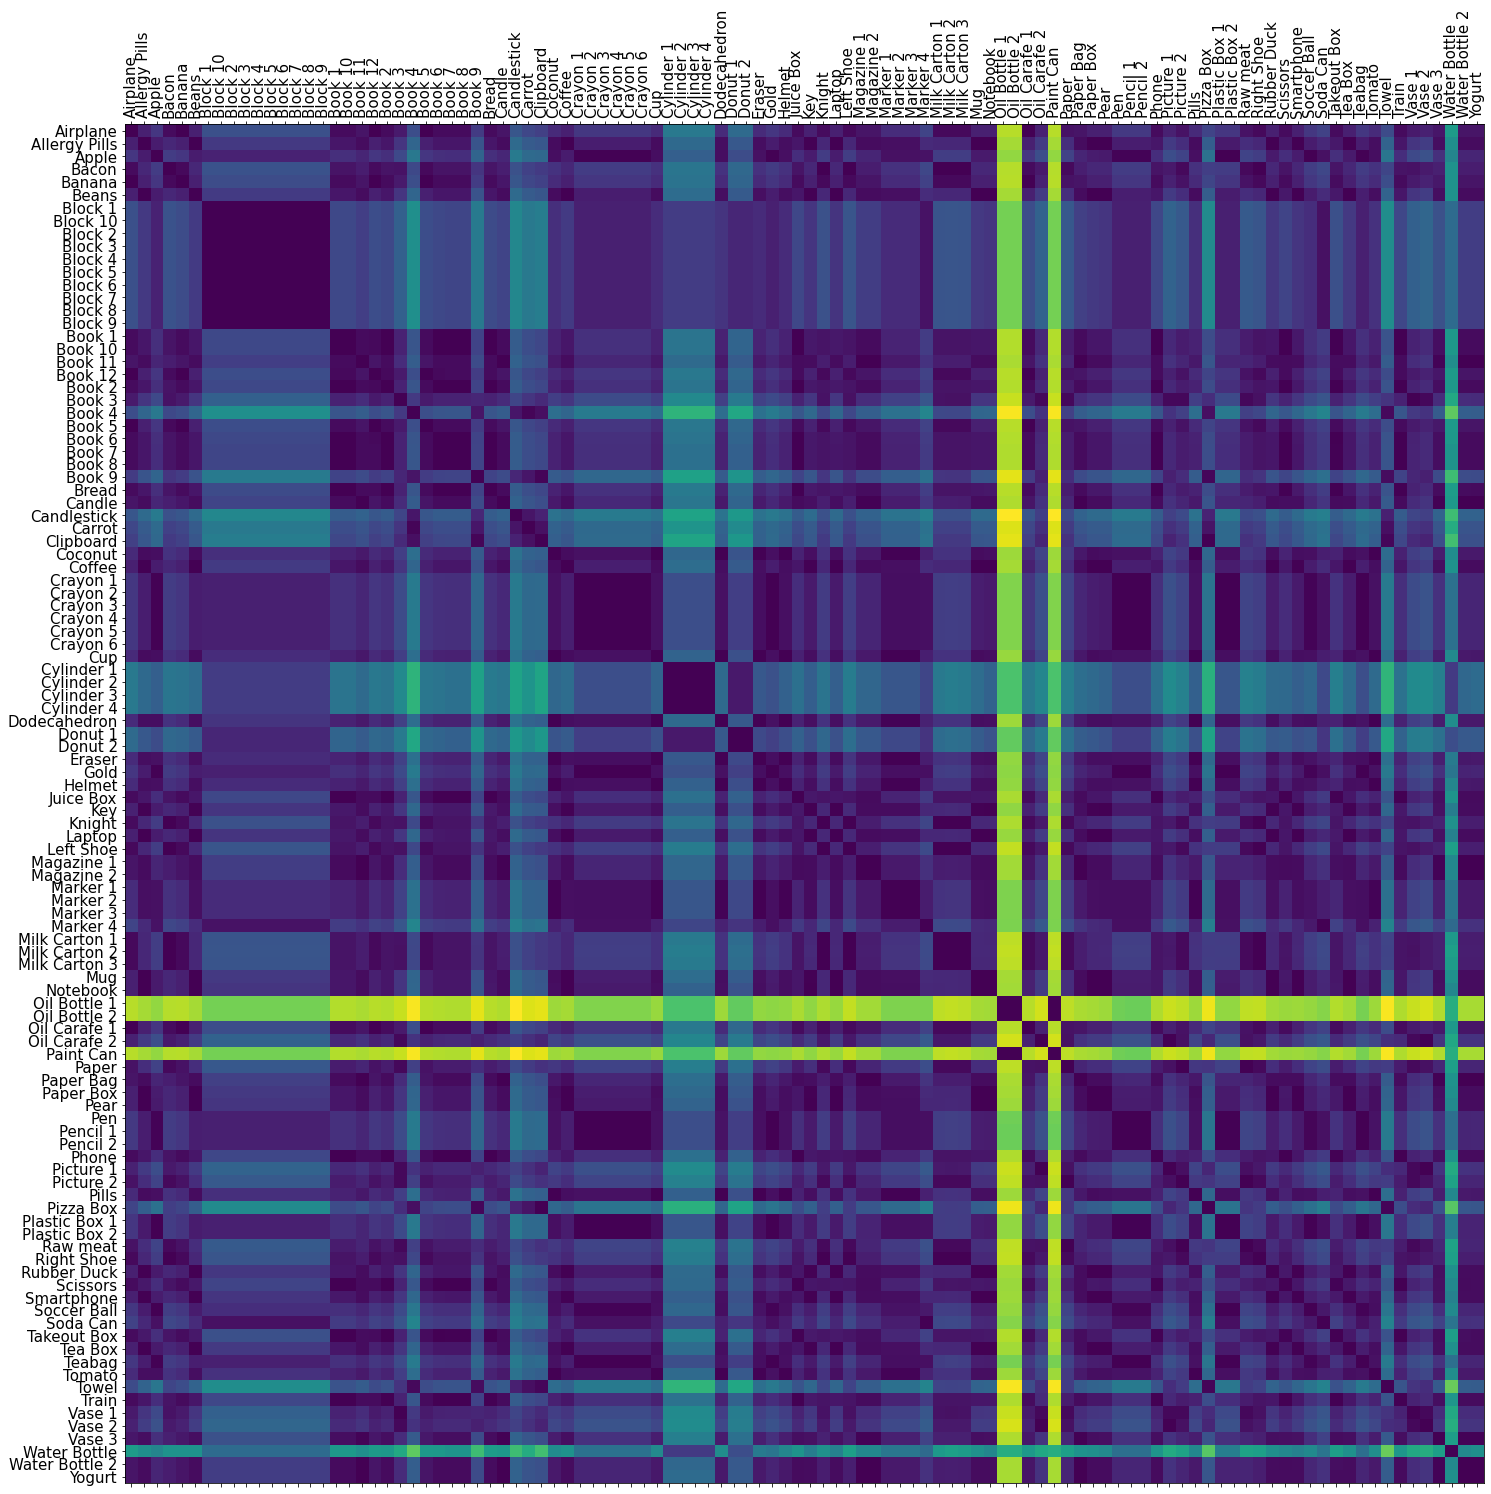

In [28]:
## Plot similarity matrix. 
similarity_matrix_full = similarity_all_objects['similarity_matrix'] + similarity_all_objects['similarity_matrix'].T 

fig, ax = plt.subplots(figsize=(25,25))
cax = ax.matshow(similarity_matrix_full, cmap='viridis')
ax.set_xticks(np.arange(len(unique_objects)))
ax.set_xticklabels(unique_objects)
ax.set_yticks(np.arange(len(unique_objects)))
ax.set_yticklabels(unique_objects)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()